In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt

from mindreadingautobots.sequence_generators import make_datasets, data_io
from mindreadingautobots.entropy_and_bayesian import entropy
import time

import gspread
from google.oauth2.service_account import Credentials


In [2]:
# Path to your service account JSON file
SERVICE_ACCOUNT_FILE = "../velvety-tube-450516-r5-2dfa430c056c.json" 


# Define the scope (Google Sheets + Google Drive API)
SCOPES = [
    "https://www.googleapis.com/auth/spreadsheets",
    "https://www.googleapis.com/auth/drive.file",  # Allows access to files the service account has access to
    "https://www.googleapis.com/auth/drive.readonly"  # Read-only access to drive files
]
# Authenticate with Google
creds = Credentials.from_service_account_file(SERVICE_ACCOUNT_FILE, scopes=SCOPES)
client = gspread.authorize(creds)

# Open the spreadsheet
SPREADSHEET_NAME = "tune_results"
spreadsheet = client.open(SPREADSHEET_NAME)

# Get names of all sheets
sheet_names = [sheet.title for sheet in spreadsheet.worksheets()]
name_to_idx = {}
for i, name in enumerate(sheet_names):
    name_to_idx[name] = i
    

In [3]:
# Get names of all sheets
sheet_names = [sheet.title for sheet in spreadsheet.worksheets()]
name_to_idx = {}
for i, name in enumerate(sheet_names):
    name_to_idx[name] = i
print("Sheets in the spreadsheet:")
for name in sheet_names:
    print(f"  {name}")

Sheets in the spreadsheet:
  RNN_sparse_majority_k5_nbits21_n2000_bf0_seed1234
  RNN_sparse_majority_k5_nbits21_n2000_bf10_seed1234
  RNN_sparse_majority_k5_nbits21_n2000_bf20_seed1234
  SAN_sparse_majority_k5_nbits21_n2000_bf0_seed1234
  SAN_sparse_majority_k5_nbits21_n2000_bf10_seed1234
  SAN_sparse_majority_k5_nbits21_n2000_bf20_seed1234
  SAN_sparse_majority_k5_nbits21_n2000_bf25_seed1234
  SAN_sparse_majority_k5_nbits21_n2000_bf30_seed1234
  SAN_sparse_majority_k5_nbits21_n2000_bf35_seed1234
  SAN_sparse_majority_k5_nbits21_n2000_bf45_seed1234
  SAN_sparse_majority_k5_nbits21_n2000_bf40_seed1234
  SAN_sparse_majority_k5_nbits21_n2000_bf15_seed1234
  SAN_sparse_majority_k5_nbits21_n2000_bf5_seed1234
  SAN_sparse_parity_k4_nbits21_n5000_bf20_seed1234
  SAN_sparse_parity_k4_nbits21_n5000_bf10_seed1234
  SAN_sparse_parity_k4_nbits21_n5000_bf0_seed1234
  RNN_sparse_majority_k5_nbits21_n2000_bf45_seed1234
  RNN_sparse_majority_k5_nbits21_n2000_bf40_seed1234
  RNN_sparse_majority_k5_nbit

In [4]:

transformer_template = 'SAN_sparse_majority_k5_nbits21_n2000_bf{}_seed1234'
rnn_template = 'RNN_sparse_majority_k5_nbits21_n2000_bf{}_seed1234'
bf_vals = list(range(0, 50, 5))
best_n = 1
best_dct = {"RNN": {"noiseless": [], "noisy": []}, 
            "SAN": {"noiseless": [], "noisy": []}}


transformer_template = 'SAN_sparse_majority_k5_nbits21_n2000_bf{}_seed1234'
rnn_template = 'RNN_sparse_majority_k5_nbits21_n2000_bf{}_seed1234'
bf_vals = list(range(0, 50, 5))
best_n = 1
best_dct = {"RNN": {"noiseless": [], "noisy": []}, 
            "SAN": {"noiseless": [], "noisy": []}}

for k in best_dct.keys():
    sheetname_template = '{}_sparse_majority_k5_nbits21_n2000_bf{}_seed1234'
    for bf in bf_vals:
        target = sheetname_template.format(k, bf)
        target_idx = name_to_idx.get(target)
        print("Loading:", target)
        if target_idx is None:
            raise ValueError(f"Sheet {target} not found.")
        sheet = spreadsheet.get_worksheet(target_idx)
        data = sheet.get_all_records()
        df = pd.DataFrame(data)
        best_noiseless = df.sort_values(by='val_acc', ascending=False).head(best_n)['noiseless_val_acc'].to_numpy()
        best_noisy = df.sort_values(by='val_acc', ascending=False).head(best_n)['val_acc'].to_numpy()
        best_dct[k]["noiseless"].append(best_noiseless)
        best_dct[k]["noisy"].append(best_noisy)


Loading: RNN_sparse_majority_k5_nbits21_n2000_bf0_seed1234
Loading: RNN_sparse_majority_k5_nbits21_n2000_bf5_seed1234
Loading: RNN_sparse_majority_k5_nbits21_n2000_bf10_seed1234
Loading: RNN_sparse_majority_k5_nbits21_n2000_bf15_seed1234
Loading: RNN_sparse_majority_k5_nbits21_n2000_bf20_seed1234
Loading: RNN_sparse_majority_k5_nbits21_n2000_bf25_seed1234
Loading: RNN_sparse_majority_k5_nbits21_n2000_bf30_seed1234
Loading: RNN_sparse_majority_k5_nbits21_n2000_bf35_seed1234
Loading: RNN_sparse_majority_k5_nbits21_n2000_bf40_seed1234
Loading: RNN_sparse_majority_k5_nbits21_n2000_bf45_seed1234
Loading: SAN_sparse_majority_k5_nbits21_n2000_bf0_seed1234
Loading: SAN_sparse_majority_k5_nbits21_n2000_bf5_seed1234
Loading: SAN_sparse_majority_k5_nbits21_n2000_bf10_seed1234
Loading: SAN_sparse_majority_k5_nbits21_n2000_bf15_seed1234
Loading: SAN_sparse_majority_k5_nbits21_n2000_bf20_seed1234
Loading: SAN_sparse_majority_k5_nbits21_n2000_bf25_seed1234
Loading: SAN_sparse_majority_k5_nbits21_n200

In [5]:

all_H = []
all_mle = []
p_bitflips = [bf / 100 for bf in bf_vals]
def sparse_majority_k5(n_data, n_bits, p_bitflip, seed, subseq_idx=None):
    return make_datasets.sparse_majority_k_n(n_bits, 5, n_data, p_bitflip, seed, subseq_idx=subseq_idx)

# Generate data with bitflip values
seed = 1234 
n_data = 100000 # ~maximum~ amount of data to analyze
inc = 50000 # increment at which to check convergence
assert inc < n_data
n_bits = 6 # HACK: We only consider the bits that actually contribute to the majority vote
intermediate_idx = list(range(inc, n_data, inc))

all_H = []
all_mle_noisy = []
all_mle_noiseless = []

for i in range(len(p_bitflips)):
    t0 = time.time()
    X, Z, idx = sparse_majority_k5(n_data, n_bits, p_bitflips[i], seed)
    print("generated data for p_bitflip = ", p_bitflips[i], " took ", time.time() - t0, " seconds")
    t0 = time.time()
    # compute the mle performance and the mle lookup table for this dataset
    H_results, mle_results, lookup_results = entropy.empirical_entropy_estimate(Z, intermediate_idx=intermediate_idx)
    print("computed entropy for p_bitflip = ", p_bitflips[i], " took ", time.time() - t0, " seconds")
    all_H.append(H_results)
    all_mle_noisy.append(mle_results)
    # compute the accuracy of MLE(trained on noisy) predicting the noiseless data
    t0 = time.time()
    mle_noiseless = entropy.compute_mle_with_lookup(X, lookup_results[-1])
    print("computed noiseless MLE for p_bitflip = ", p_bitflips[i], " took ", time.time() - t0, " seconds")
    all_mle_noiseless.append(mle_noiseless)

generated data for p_bitflip =  0.0  took  1.6942496299743652  seconds
computed entropy for p_bitflip =  0.0  took  0.24406647682189941  seconds
computed noiseless MLE for p_bitflip =  0.0  took  0.8607163429260254  seconds
generated data for p_bitflip =  0.05  took  1.1327838897705078  seconds
computed entropy for p_bitflip =  0.05  took  0.46866273880004883  seconds
computed noiseless MLE for p_bitflip =  0.05  took  0.8550152778625488  seconds
generated data for p_bitflip =  0.1  took  1.6781365871429443  seconds
computed entropy for p_bitflip =  0.1  took  0.4817390441894531  seconds
computed noiseless MLE for p_bitflip =  0.1  took  1.0001397132873535  seconds
generated data for p_bitflip =  0.15  took  1.6818311214447021  seconds
computed entropy for p_bitflip =  0.15  took  0.46802449226379395  seconds
computed noiseless MLE for p_bitflip =  0.15  took  1.0062570571899414  seconds
generated data for p_bitflip =  0.2  took  1.6624963283538818  seconds
computed entropy for p_bitfl

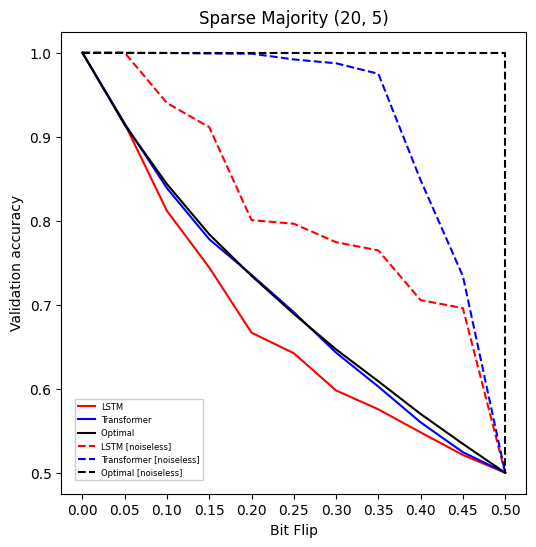

In [16]:
fig, axes = plt.subplots(1, 1, figsize=(6, 6))

# xvals = np.array([x[-1] for x in all_H])
xvals = p_bitflips
mle_noisy_final = np.array([x[-1] for x in all_mle_noisy])

rnn_noiseless = np.array(best_dct["RNN"]["noiseless"]).flatten()
rnn_noisy = np.array(best_dct["RNN"]["noisy"]).flatten()
san_noiseless = np.array(best_dct["SAN"]["noiseless"]).flatten()
san_noisy = np.array(best_dct["SAN"]["noisy"]).flatten()

# Add point at (0.5, 0.5) to each array
xvals = np.append(xvals, 0.5)
rnn_noisy = np.append(rnn_noisy, 0.5)
san_noisy = np.append(san_noisy, 0.5)
mle_noisy_final = np.append(mle_noisy_final, 0.5)
rnn_noiseless = np.append(rnn_noiseless, 0.5)
san_noiseless = np.append(san_noiseless, 0.5)

# Plot using all points including (0.5, 0.5)
axes.plot(xvals, rnn_noisy, label='LSTM', c='r', ls='-')
axes.plot(xvals, san_noisy, label='Transformer', c='b', ls='-')
axes.plot(xvals, mle_noisy_final, label='Optimal ', c='k', ls='-')

axes.plot(xvals, rnn_noiseless, label='LSTM [noiseless]', c='r', ls='--')
axes.plot(xvals, san_noiseless, label='Transformer [noiseless]', c='b', ls='--')
# Plot noiseless optimal as three connected points
axes.plot([0, 0.5, 0.5], [1, 1, 0.5], label='Optimal [noiseless]', c='k', ls='--')

leg_prop = {'size': 8}
axes.legend(prop={'size': 6}, framealpha=1, bbox_to_anchor=(0.02, 0.02), loc='lower left')
axes.set_xlabel('Bit Flip')
axes.set_ylabel('Validation accuracy')
axes.set_title('Sparse Majority (20, 5)')
axes.set_xticks(np.append(p_bitflips, 0.5))